In [1]:
import scanpy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp
from scipy.stats import pearsonr

In [2]:
input_file = "/Users/manuel/OneDrive/jupyter_notebooks/scanpy_scRNA-seq_analysis/GSM3017261_150000_CNS_nuclei.h5ad"
sp_dge = sp.read(input_file)

In [3]:
input_file = "/Users/manuel/OneDrive/jupyter_notebooks/scanpy_scRNA-seq_analysis/GSM3017261_150000_CNS_nuclei.h5ad"
orig = sp.read(input_file)

In [ ]:
sp.pl.highest_expr_genes(sp_dge, n_top=20, )

In [ ]:
sp.pp.filter_cells(sp_dge, min_genes=200)

In [ ]:
sp.pp.filter_genes(sp_dge, min_cells=3)

In [ ]:
qc_metrics = sp.pp.calculate_qc_metrics(sp_dge, inplace=True)

In [ ]:
mito_genes = sp_dge.var_names.str.startswith('mt')

In [ ]:
np.sum(mito_genes)

In [ ]:
sp.pl.violin(sp_dge, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [ ]:
plt.scatter(sp_dge.obs['total_counts'],sp_dge.obs['n_genes_by_counts'])

In [ ]:
plt.hist(sp_dge.obs["n_genes_by_counts"], histtype='bar', rwidth=0.8)

In [ ]:
plt.hist(sp_dge.obs["total_counts"], histtype='bar', rwidth=0.8)

# My DGE with d=1

In [4]:
input_file = "/Users/manuel/OneDrive/jupyter_notebooks/scanpy_scRNA-seq_analysis/dge_matrix_umid1_presel.h5ad"
sp_dge_my_d1 = sp.read(input_file)

In [5]:
input_file = "/Users/manuel/OneDrive/jupyter_notebooks/scanpy_scRNA-seq_analysis/dge_matrix_umid1_presel.h5ad"
my = sp.read(input_file)

In [ ]:
sp.pp.calculate_qc_metrics(sp_dge_my_d1, inplace=True)

In [ ]:
sp.pl.highest_expr_genes(sp_dge_my_d1, n_top=20, )

In [ ]:
plt.scatter(sp_dge_my_d1.obs['total_counts'],sp_dge_my_d1.obs['n_genes_by_counts'])

In [ ]:
plt.hist(sp_dge_my_d1.obs["n_genes_by_counts"], histtype='bar', rwidth=0.4)

In [ ]:
plt.hist(sp_dge_my_d1.obs["total_counts"], histtype='bar', rwidth=0.5)

In [ ]:
lower_lim = sp_dge_my_d1.obs['total_counts'] > 400
upper_lim = sp_dge_my_d1.obs['total_counts'] < 100

print(np.sum(lower_lim))
print(np.sum(upper_lim))
print(sum(lower_lim | upper_lim))

## obtain expression values of Malat1 for all cells 

In [ ]:
# my data
index_d1 = sp_dge_my_d1.var_names.get_loc('Malat1')
counts_d1 = sp_dge_my_d1.X[:, index_d1]

# original data

# remove empty spaces!!!
genes = sp_dge.var_names.tolist()
genes_new = []
for gene in genes:
    genes_new.append(gene.split(" ")[0])
sp_dge.var_names = genes_new

index_orig = sp_dge.var_names.get_loc('Malat1')
counts_orig = sp_dge.X[:, index_orig]

In [ ]:
# Sort both counts

counts_orig = counts_orig.toarray()  # csc_matrix to ndarray
counts_orig.sort(axis=0) # sort 1 dimensional array
counts_orig_list = []
for count in counts_orig:
    counts_orig_list.append(count[0])
# counts_orig = counts_orig.tolist() # convert ndarray to list


counts_d1.sort(axis=0) # is already a ndarray
counts_d1 = counts_d1.tolist()

In [ ]:
counts_d1 = counts_d1[-150000:]
counts_orig = counts_orig_list[-150000:]

### functions

In [6]:
def correct_gene_names(AnnData_object):
    genes = AnnData_object.var_names.tolist()
    genes_new = []
    for gene in genes:
        genes_new.append(gene.split(" ")[0])
    AnnData_object.var_names = genes_new
    
    return AnnData_object

In [7]:
def get_counts_for_gene(AnnData_object, gene_name=False, index="false"):
    # you can return the counts for one gene based on the gene name or index in the
    # AnnData_object 
        
    if index == "false":
        index = AnnData_object.var_names.get_loc(gene_name)
    
    return AnnData_object.X[:, index]
    

In [8]:
def sort_counts_ascending(counts):
    counts_list = []
    
    if isinstance(counts, scp.sparse.csc.csc_matrix):
        counts = counts.toarray()  # csc_matrix to ndarray
        counts.sort(axis=0) # sort 1 dimensional array
        for count in counts:
            counts_list.append(count[0])
    else:
        counts.sort(axis=0) # is already a ndarray
        counts_list = counts.tolist()
        
    return counts_list

In [9]:
def linear_fit(y_values, x_values, no_cells):
    # two lists of values for which a linear model should be calculated
    # returns a list containing intercept and slope
    from sklearn.linear_model import LinearRegression
    
    # select a fraction of cells
    y = y_values[-no_cells:]
    x = x_values[-no_cells:]
    
    # reshape 1D np.array to 2D np.array
    y = np.array(y).reshape(-1,1)
    x = np.array(x).reshape(-1, 1)
    
    # fit linear model
    regressor = LinearRegression()
    regressor.fit(y, x)

    return [regressor.intercept_, regressor.coef_[0]]

In [ ]:
x_values = sort_counts_ascending(get_counts_for_gene(correct_gene_names(sp_dge), 'Malat1'))

In [ ]:
y_values = sort_counts_ascending(get_counts_for_gene(sp_dge_my_d1, 'Malat1'))

In [ ]:
def calculate_linear_fit(AnnData_object_x, AnnData_object_y):
    
    gene_counts_x = [0]*len(AnnData_object_x.var)
    
    # correct gene names (remove empty spaces)
    AnnData_object_x = correct_gene_names(AnnData_object_x)
    
    for gene_no in range(len(AnnData_object_x.var)):
        gene_counts_x.append(sort_counts_ascending(get_counts_for_gene(AnnData_object_x, index=gene_no)))
        
    
    gene_counts_y = [0]*len(AnnData_object_y.var)
    for gene_no in range(len(AnnData_object_y.var)):
        gene_counts_y.append(sort_counts_ascending(get_counts_for_gene(AnnData_object_y, index=gene_no)))
        
    return gene_counts_x, gene_counts_y



In [ ]:
counts_x, counts_y = calculate_linear_fit(sp_dge, sp_dge_my_d1)

In [ ]:
x = np.linspace(0, 10, 1000)

In [ ]:
plt.scatter(counts_d1, counts_orig)
plt.plot(x, 16.27365605*x-10.35588723, '-r')
plt.plot(x, 30.86250149*x-76.28094612, '-b')

## calculating pearson correlation coefficient

In [ ]:
o = pd.DataFrame()
o["col1"] = counts_orig
o["col2"] = counts_d1
pearsoncorr = o.corr(method='pearson')
pearsoncorr

## fit linear model

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
counts_d1 = counts_d1[-1000:]
counts_orig = counts_orig[-1000:]

In [ ]:
ff = np.array(counts_d1).reshape(-1,1)
gg = np.array(counts_orig).reshape(-1, 1)

In [ ]:
regressor = LinearRegression()

In [ ]:
regressor.fit(ff, gg)

In [ ]:
print(regressor.intercept_)
print(regressor.coef_)

### select rows in dataframe by row number

In [ ]:
sp_dge.var.iloc[57]

# ------------------------------

remove cells with more than 2000 genes

In [ ]:
sp_dge_my_d1_fil = sp_dge_my_d1[sp_dge_my_d1.obs.n_genes_by_counts < 2000, :]

In [ ]:
sp_dge_my_d1_fil

In [ ]:
plt.hist(sp_dge_my_d1_fil.obs["n_genes_by_counts"], histtype='bar', rwidth=0.4)

In [ ]:
plt.scatter(sp_dge_my_d1_fil.obs['total_counts'],sp_dge_my_d1_fil.obs['n_genes_by_counts'])

# My DGE with d=0

In [ ]:
input_file = "/Volumes/win_mac/dge_matrix_umid0/dge_matrix_umid0.h5ad"
sp_dge_my_d0 = sp.read(input_file)

In [ ]:
sp_dge_my_d0

In [ ]:
sp.pl.highest_expr_genes(sp_dge_my_d0, n_top=20, )

### how many matching HVGs exist?
517

In [10]:
# find HVGs original dataset
sp.pp.normalize_total(sp_dge, target_sum=1e4)
sp.pp.log1p(sp_dge)
sp_dge.raw = sp_dge
sp.pp.highly_variable_genes(sp_dge, min_mean=0.0125, max_mean=3, min_disp=0.5)
sp_dge = sp_dge[:, sp_dge.var.highly_variable]

In [11]:
correct_gene_names(sp_dge)

View of AnnData object with n_obs × n_vars = 156049 × 3442 
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [12]:
# find HVGs my dataset
sp.pp.normalize_total(sp_dge_my_d1, target_sum=1e4)
sp.pp.log1p(sp_dge_my_d1)
sp_dge_my_d1.raw = sp_dge_my_d1
sp.pp.highly_variable_genes(sp_dge_my_d1, min_mean=0.0125, max_mean=3, min_disp=0.5)
sp_dge_my_d1 = sp_dge_my_d1[:, sp_dge_my_d1.var.highly_variable]

In [15]:
no_matches(sp_dge_my_d1.var_names, sp_dge.var_names)

517

In [17]:
matches = find_matches(sp_dge_my_d1.var_names, sp_dge.var_names)

In [16]:
# find number of matches in two lists

def no_matches(list1, list2):
    count = 0
    for item in list1:
        if item in list2:
            count += 1
    return count

def find_matches(list1, list2):
    matches = []
    for item in list1:
        if item in list2:
            matches.append(item)
    return matches

In [ ]:
my_hvgs = sp_dge_my_d1.var_names
orig_hvgs = sp_dge.var_names

### how many of the orig HVGs are in my dataset?

3281
3442
161

In [ ]:
# delete spaces in gene names
correct_gene_names(orig)

In [ ]:
print(no_matches(my.var_names, orig_hvgs))
print(len(orig_hvgs))
print(len(orig_hvgs)-no_matches(my.var_names, orig_hvgs))

### how many genes in my dataset are also in the original dataset?

21822  
23004  
1182  
1.054165521033819

In [ ]:
print(no_matches(my.var_names, orig.var_names))
print(len(my.var_names))
print(len(my.var_names) - no_matches(my.var_names, orig.var_names))
print(len(my.var_names)/(no_matches(my.var_names, orig.var_names)))

### do my HVGs have a linear relationship to the corresponding genes in the orig dataset?

In [ ]:
my.var_names

In [ ]:
my_hvg_counts = []
orig_hvg_counts = []

for gene_name in my_hvgs:
    if gene_name in my.var_names and gene_name in orig.var_names:
        my_hvg_counts.append(get_counts_for_gene(my, gene_name=gene_name))
        orig_hvg_counts.append(get_counts_for_gene(orig, gene_name=gene_name))

In [ ]:
my_hvg_counts_sorted = []
orig_hvg_counts_sorted = []
for i in range(len(my_hvg_counts)):
    my_hvg_counts_sorted.append(sort_counts_ascending(my_hvg_counts[i]))
    orig_hvg_counts_sorted.append(sort_counts_ascending(orig_hvg_counts[i]))

In [ ]:
# the datasets have a differen number of cells
# therefore they have to be casted to the same length
my_hvg_counts_casted = []
orig_hvg_counts_casted = []
for i in range(len(orig_hvg_counts_sorted)):
    my_hvg_counts_casted.append(my_hvg_counts_sorted[i][-150000:])
    orig_hvg_counts_casted.append(orig_hvg_counts_sorted[i][-150000:])

In [ ]:
o = pd.DataFrame()
o["col1"] = counts_orig
o["col2"] = counts_d1
pearsoncorr = o.corr(method='pearson')
pearsoncorr

In [ ]:
o = pd.DataFrame()

In [ ]:
o["col2"] = my_hvg_counts_casted[0]

In [ ]:
o["col1"] = orig_hvg_counts_casted[0]

In [ ]:
pearsoncorr = o.corr(method='pearson')

In [ ]:
pearsonr

### do my HVGs have a linear relationship to the corresponding genes in the orig dataset?

rather no.... 

In [27]:
correct_gene_names(orig)

AnnData object with n_obs × n_vars = 156049 × 26894 

In [28]:
my_hvg_counts = []
orig_hvg_counts = []

for gene_name in matches:
    my_hvg_counts.append(get_counts_for_gene(my, gene_name=gene_name))
    orig_hvg_counts.append(get_counts_for_gene(orig, gene_name=gene_name))

In [29]:
my_hvg_counts_sorted = []
orig_hvg_counts_sorted = []
for i in range(len(my_hvg_counts)):
    my_hvg_counts_sorted.append(sort_counts_ascending(my_hvg_counts[i]))
    orig_hvg_counts_sorted.append(sort_counts_ascending(orig_hvg_counts[i]))

In [30]:
# the datasets have a differen number of cells
# therefore they have to be casted to the same length
my_hvg_counts_casted = []
orig_hvg_counts_casted = []
for i in range(len(orig_hvg_counts_sorted)):
    my_hvg_counts_casted.append(my_hvg_counts_sorted[i][-150000:])
    orig_hvg_counts_casted.append(orig_hvg_counts_sorted[i][-150000:])

In [37]:
corr = []
for i in range(len(my_hvg_counts_casted)):
    cor, conf = pearsonr(my_hvg_counts_casted[i], orig_hvg_counts_casted[i])
    corr.append(cor)

In [44]:
count = 0
for entry in corr:
    if entry > 0.5:
        count += 1
print(count)

462


### do my HVGs have the same linear relationship for all genes?
yeah... kind of  

0.5990562624267372

In [53]:
slopes = []
for i in range(len(my_hvg_counts_casted)):
    slopes.append(linear_fit(my_hvg_counts_casted[i], orig_hvg_counts_casted[i], no_cells=150000)[1])

In [55]:
np.std(slopes)

0.5990562624267372

### clustering of the same HVGs of both datasets
If I only take the HVGs that are present in both datasets, do those datasets produce the same clustering?


YES!

In [84]:
# only keep genes that are classified HVG in both datasets

# my dataset
keep = [False]*len(my.var_names)
for i in range(len(my.var_names)):
    if my.var_names[i] in matches:
        keep[i] = True
        
my.var["keep"] = keep 

my_kept = my[:, my.var["keep"]]  # the shortened dataset

# the original dataset
keep = [False]*len(orig.var_names)
for i in range(len(orig.var_names)):
    if orig.var_names[i] in matches:
        keep[i] = True
        
orig.var["keep"] = keep

orig_kept = my[:, my.var["keep"]]  # the shortened dataset

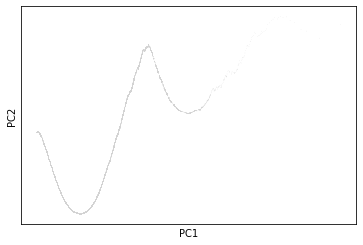

In [88]:
sp.tl.pca(orig_kept, svd_solver='arpack')
sp.pl.pca(orig_kept)

sp.pp.neighbors(orig_kept, n_neighbors=10, n_pcs=40)
sp.tl.umap(orig_kept)

sp.tl.leiden(orig_kept)

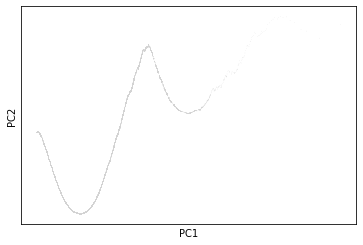

In [89]:
sp.tl.pca(my_kept, svd_solver='arpack')
sp.pl.pca(my_kept)

sp.pp.neighbors(my_kept, n_neighbors=10, n_pcs=40)
sp.tl.umap(my_kept)

sp.tl.leiden(my_kept)

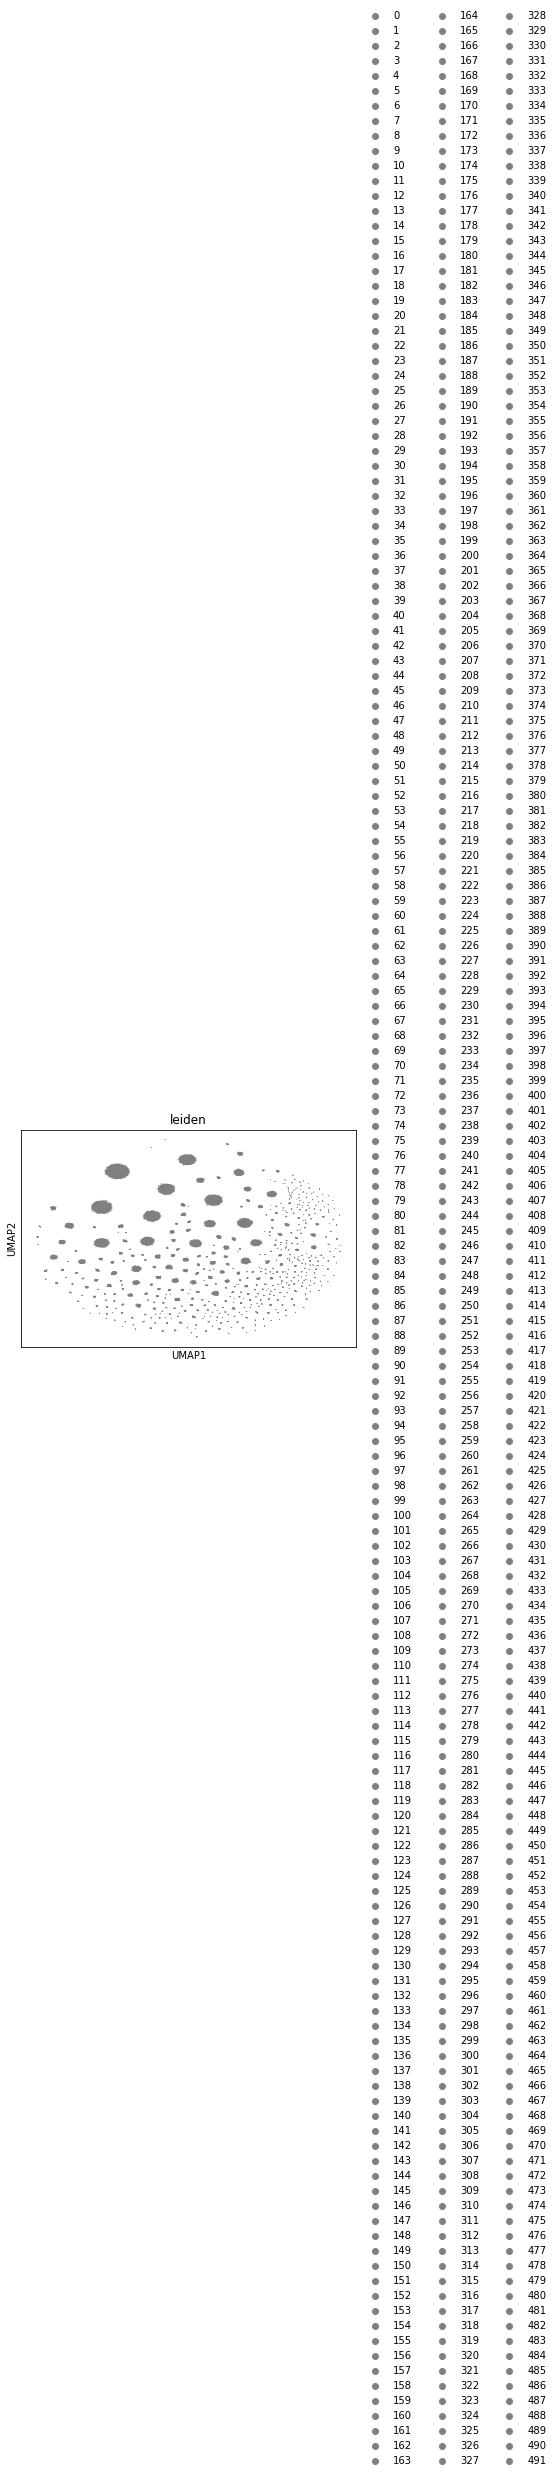

In [101]:
sp.pl.umap(orig_kept, color='leiden')

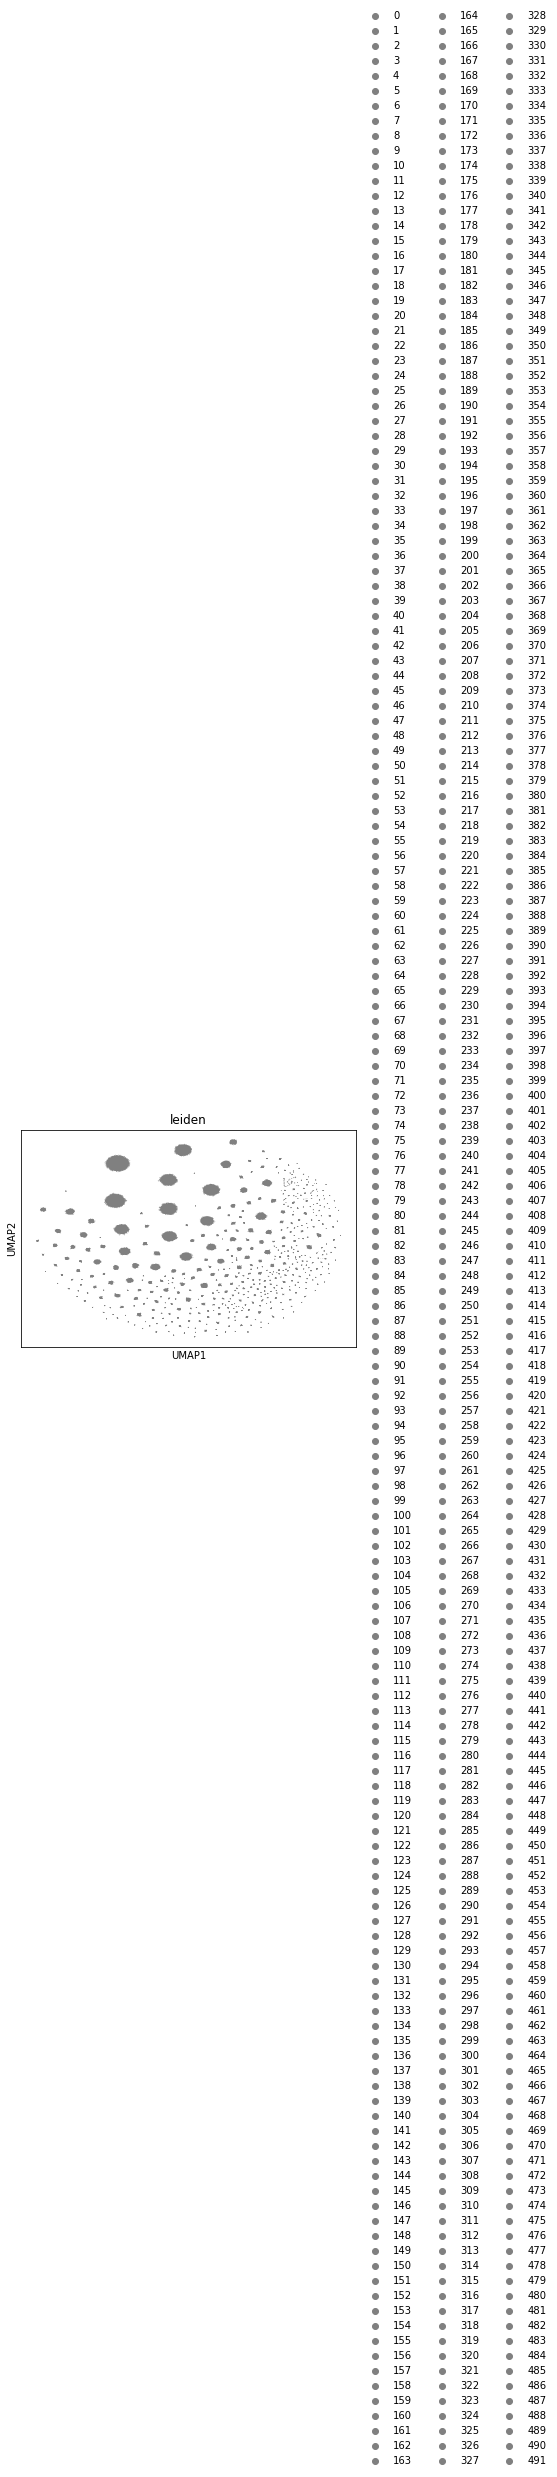

In [103]:
sp.pl.umap(my_kept, color='leiden')

# Tutorial

In [ ]:
adata = sp.read_10x_mtx('/Users/manuel/Downloads/filtered_gene_bc_matrices/hg19/',
                        var_names='gene_symbols',       
                        cache=True)

In [ ]:
# calculate QC metrics
sp.pp.calculate_qc_metrics(adata, inplace=True)

In [ ]:
plt.hist(adata.obs["n_genes_by_counts"], histtype='bar', rwidth=0.8)

In [ ]:
sp.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [ ]:
mito_genes = adata.var_names.str.startswith('MT-')

In [ ]:
# number of counts per cell that correspond to mito genes 
# divided by
# total number of counts per cell
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

In [ ]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [ ]:
sp.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [ ]:
sp.pl.scatter(adata, x='n_counts', y='percent_mito')

In [ ]:
plt.scatter(adata.obs['total_counts'],adata.obs['n_genes_by_counts'])

In [ ]:
plt.hist(adata.obs["total_counts"], histtype='bar', rwidth=0.4)

In [ ]:
adata.obs